# 11wk-2: (순환신경망) – `abc`, `abcd`, 임베딩 공간의 이해, `AbAcAd`

최규빈  
2025-05-19

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/11wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-yrZ4HbNgYDmklcumxJHSOp&si=XO2ZBUtY_m1mSFvX >}}

# 2. Imports

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 예비학습

## A. `tanh`

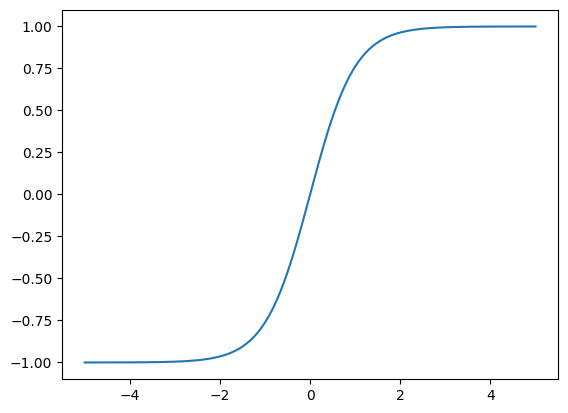

In [3]:
x = torch.linspace(-5,5,1001)
tanh = torch.nn.Tanh()
plt.plot(x,tanh(x))

## B. `softmax`

In [18]:
logits = torch.randn((10,5))
logits

In [23]:
probs = torch.nn.functional.softmax(logits,dim=1)
probs

# 4. `abc`

## A. Data

In [4]:
txt = list('abc'*100)
txt[:10]

In [5]:
df_train = pd.DataFrame({'x': txt[:-1], 'y': txt[1:]})
df_train[:5]

In [6]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2}))

## B. MLP – 하나의 은닉노드

In [7]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=1),
    torch.nn.Tanh(), # 외우세여. 
    torch.nn.Linear(in_features=1, out_features=3),
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [8]:
for epoc in range(50):
    ## 1 
    netout = net(x) 
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

/home/cgb3/anaconda3/envs/dl2025/lib/python3.9/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

In [9]:
netout.argmax(axis=1),y

## C. 적합결과의 해석 ($\star$)

`-` 네트워크 분해

In [10]:
ebdd, tanh, linr = net 

`-` 시각화

/tmp/ipykernel_904197/4240458058.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

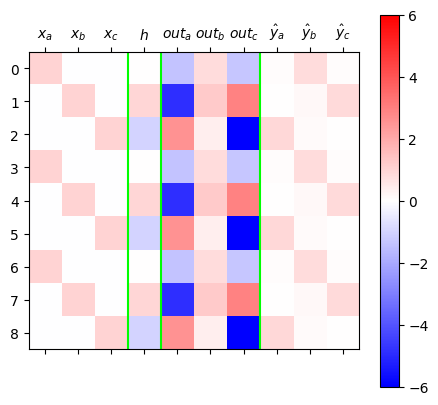

In [11]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout,yhat],axis=1)
#---#
plt.matshow(mat[:9, :],cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(2.5,color="lime")
plt.axvline(3.5,color="lime")
plt.axvline(6.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[r"$x_a$",r"$x_b$",r"$x_c$",r"$h$",r"$out_a$",r"$out_b$",r"$out_c$",r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$"]);
plt.tight_layout()

-   netout 을 보는 요령: 가장 빨간부분이 예측값이 된다.
-   문제1: $out_b$의 경우 애매한 색깔만 있음. 네트워크가 정답을 잘
    모른다는 의미.
-   문제1의 원인: $out_b$의 경우에 대응하는 ${\boldsymbol h}$를 살펴보니
    흰색임. 이것은 값이 0이라는 의미인데 이때는 ${\boldsymbol h}$ 에
    걸리는 선형변환 $linr_{1 \to 3}$ 의 weight 가 의미없고 bias만
    의미있기 때문에 특징을 잡기에 불리하다.
-   문제2: ${\boldsymbol h}$가 흰색이면(=0이 나오면) 불리하며, 확실한
    색을 가지고 있는것이 유리함. 그렇지만 확실한 색인 빨강 파랑은 이미
    차지된 상태라서 어쩔수 없이 흰색으로 선택된 것.
-   문제2를 해결하는 방법: $a,b,c$라는 세문자를 표현하기에
    $(-1,1)$사이의 숫자는 너무 불리함..

## D. MLP – 두개의 은닉노드

`-` 적합

In [102]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=3),
)
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [103]:
for epoc in range(50):
    ## 1 
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

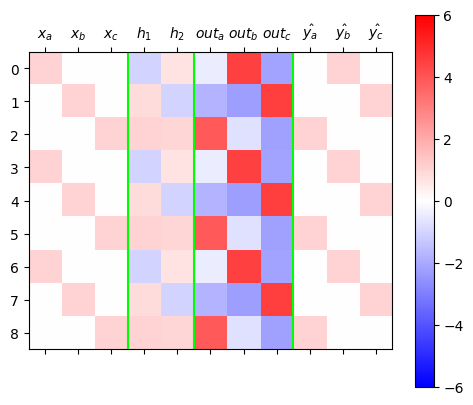

In [88]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout,yhat],axis=1)
#---#
plt.matshow(mat[:9,:] ,cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(2.5,color="lime")
plt.axvline(4.5,color="lime")
plt.axvline(7.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10],labels=[r"$x_a$", r"$x_b$", r"$x_c$",r"$h_1$",r"$h_2$",r"$out_a$",r"$out_b$",r"$out_c$",r"$\hat{y_a}$",r"$\hat{y_b}$",r"$\hat{y_c}$"]);

`-` 시각화결과해석: 깔끔함. netout의 가장 빨간부분도 너무 명확함.
${\boldsymbol h}$가 0이 아닌 값으로 학습되어있음

-   x=a $\Rightarrow$ h=(파,빨) $\Rightarrow$ y=b
-   x=b $\Rightarrow$ h=(빨,파) $\Rightarrow$ y=c
-   x=c $\Rightarrow$ h=(빨,빨) $\Rightarrow$ y=a
-   h = (파,파) 는 사용하지 않음. –\> 문자열 d를 하나 더 쓸수 있는
    공간이 $h$에 있다고 해석할 수 있음..

# 5. `abcd`

## A. Data

In [104]:
txt = list('abcd'*100)
txt[:10]

In [105]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [106]:
x = torch.tensor(df_train.x.map({'a':0, 'b':1, 'c':2, 'd':3}))
y = torch.tensor(df_train.y.map({'a':0, 'b':1, 'c':2, 'd':3}))

## B. MLP – 하나의 은닉노드

`-` 학습

In [108]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=4)
)
ebdd,tanh,linr = net 
ebdd.weight.data = torch.tensor([[-0.3333],[-2.5000],[5.0000],[0.3333]])
linr.weight.data = torch.tensor([[1.5000],[-6.0000],[-2.0000],[6.0000]])
linr.bias.data = torch.tensor([0.1500, -2.0000,  0.1500, -2.000])
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [109]:
for epoc in range(50):
    ## 1 
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

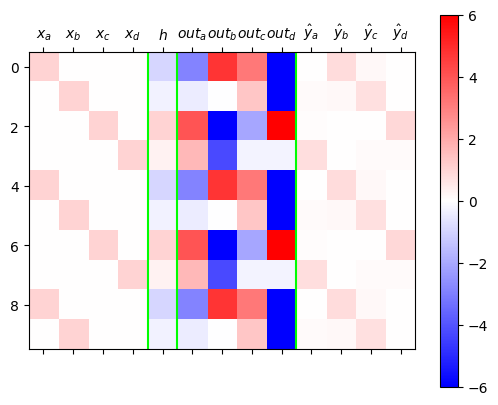

In [130]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout,yhat],axis=1)
#---#
plt.matshow(mat[:10, :],cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(3.5,color="lime")
plt.axvline(4.5,color="lime")
plt.axvline(8.5,color="lime")
plt.xticks(
    ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    labels=[
        r"$x_a$",r"$x_b$",r"$x_c$",r"$x_d$",
        r"$h$",
        r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",
        r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);

## C. MLP – 두개의 은닉노드

`-` 학습

In [132]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [133]:
for epoc in range(50):
    ## 1 
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

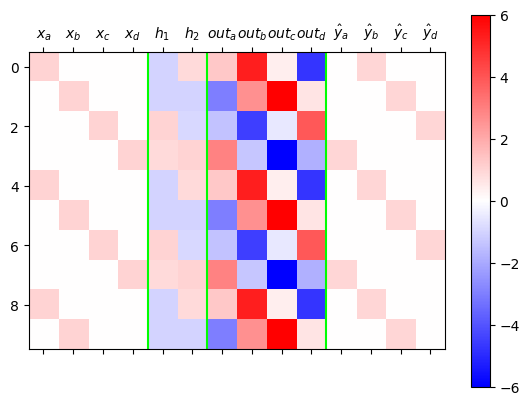

In [139]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout,yhat],axis=1)
#---#
plt.matshow(mat[:10, :],cmap="bwr",vmin=-6,vmax=6)
plt.colorbar()
plt.axvline(3.5,color="lime")
plt.axvline(5.5,color="lime")
plt.axvline(9.5,color="lime")
plt.xticks(
    ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13],
    labels=[
        r"$x_a$",r"$x_b$",r"$x_c$",r"$x_d$",
        r"$h_1$",r"$h_2$",
        r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",
        r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);

## D. 비교실험

In [140]:
class Net1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,1)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(1,4)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        ## 정의 끝
        return netout

In [141]:
class Net2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,2)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(2,4)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        ## 정의 끝
        return netout

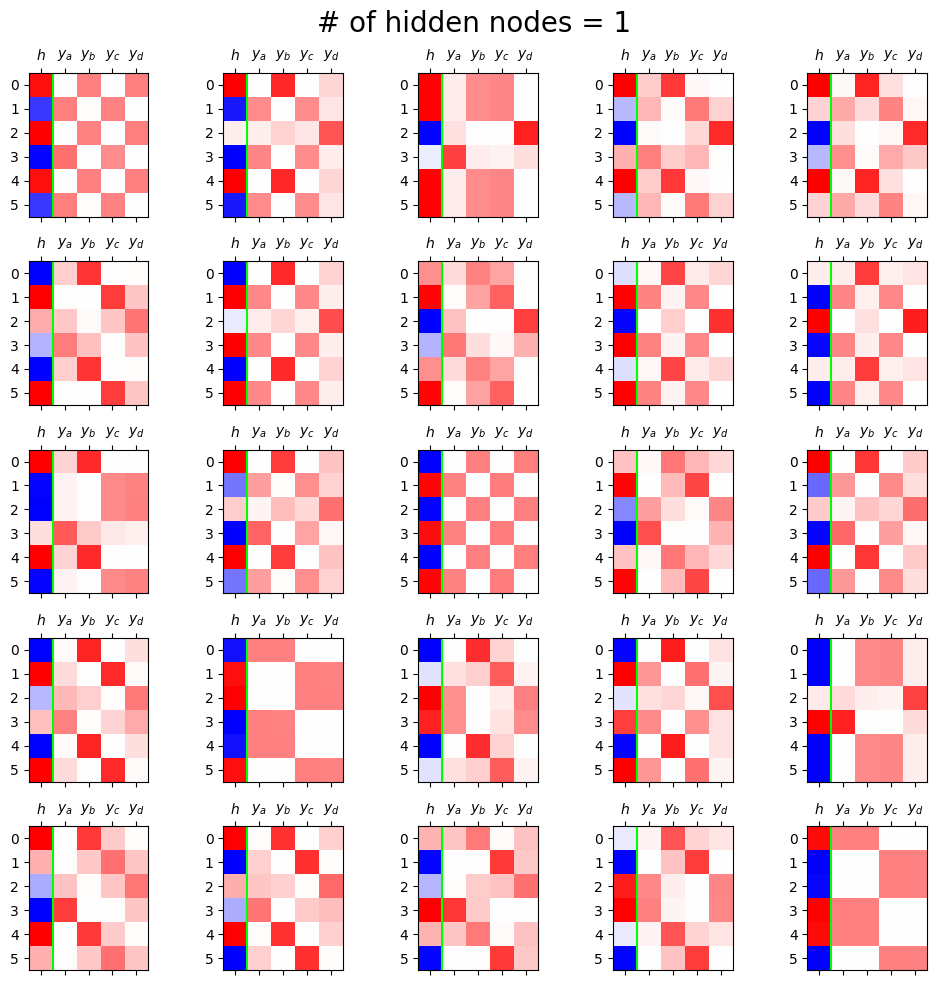

In [145]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Net1()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data
        yhat = torch.nn.functional.softmax(net(x),dim=1).data
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat[:6, :],cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(0.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4],labels=[r"$h$",r"$y_a$",r"$y_b$",r"$y_c$",r"$y_d$"])
fig.suptitle("# of hidden nodes = 1", size=20)
fig.tight_layout()

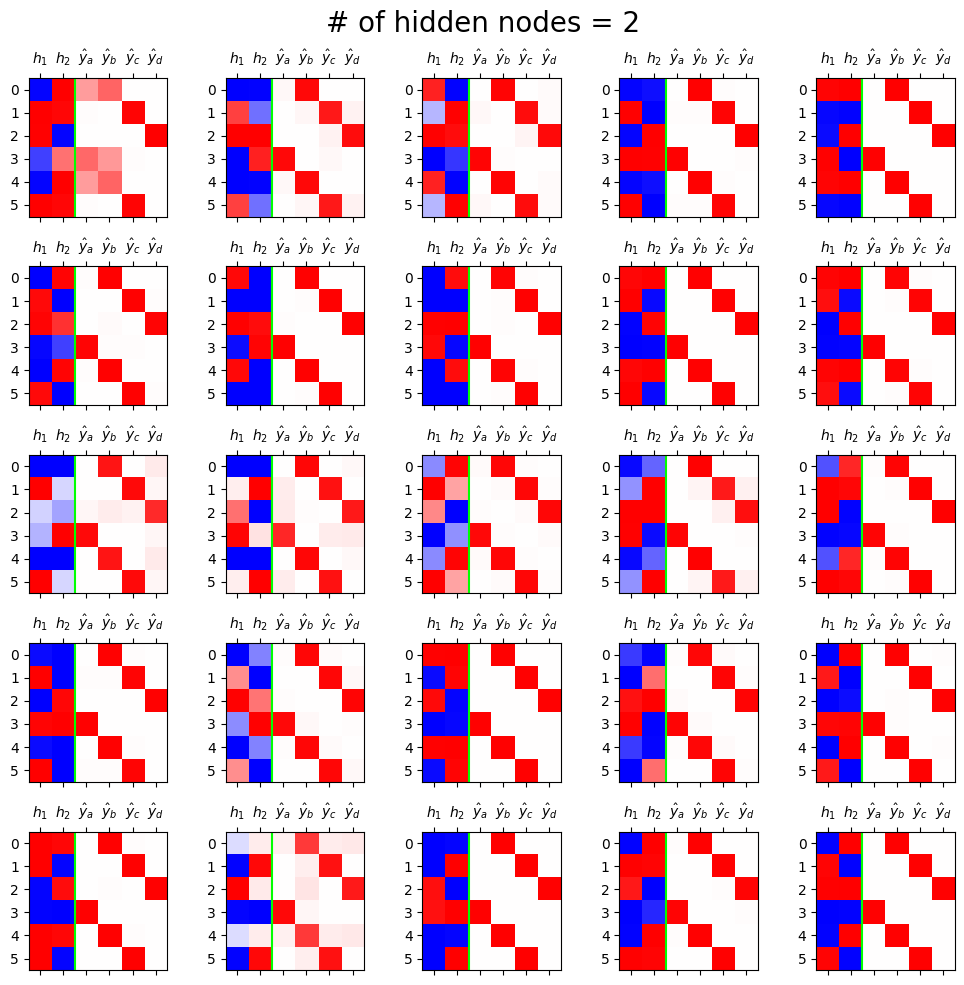

In [147]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Net2()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data
        yhat = torch.nn.functional.softmax(net(x),dim=1).data
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat[:6, :],cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(1.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4,5],labels=[r"$h_1$",r"$h_2$",r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"])
fig.suptitle("# of hidden nodes = 2", size=20)
fig.tight_layout()        

# 6. ${\boldsymbol h}$ 에 대하여 $(\star\star\star$)

`-` ${\boldsymbol h}$는 사실 문자열 “abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
    ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
    ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
    ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

# 7. `AbAbAc` – 실패

## A. Data

`-` 데이터 정리

In [148]:
txt = list('AbAcAd'*50)
txt[:10]

In [149]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [150]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))

In [151]:
x[:8],y[:8]

## B. 풀이 – 실패

In [171]:
net = torch.nn.Sequential(
    torch.nn.Embedding(4,2),
    torch.nn.Tanh(),
    torch.nn.Linear(2,4)
)
ebdd,tanh,linr = net
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
#---#
for epoc in range(200):
    # 1 
    netout = net(x)
    # 2 
    loss = loss_fn(netout,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

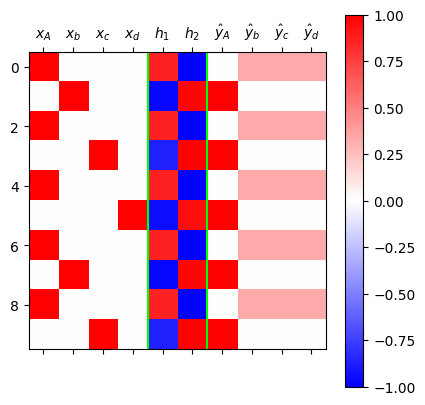

In [172]:
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x))
yhat = torch.nn.functional.softmax(net(x),dim=1)
mat = torch.concat([X,h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.axvline(3.5,color="lime")
plt.axvline(5.5,color="lime")
plt.xticks(
    ticks=range(10),
    labels=[
        r"$x_A$",r"$x_b$",r"$x_c$",r"$x_d$",
        r"$h_1$",r"$h_2$",
        r"$\hat{y}_A$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"
    ]);

-   100번 시도해봤자 100번 망함

## C. Discussions

`-` 왜 망했을까?

`-` `hello`[1] 문자열을 맞출 수 있을까?

-   이전시점을 많이 고려하면 맞출수는 있음.
-   그러나 이러한 방법들은 (ARMA, N-grams) 한계가 뚜렷 $\to$
    순환신경망의 등장

[1] 2015년 Andrej Karpathy(안드레이 카파시)의 “전설적인” 블로그
<https://karpathy.github.io/2015/05/21/rnn-effectiveness/> 에 담긴 예제